In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools.load_data import *
from alvra_tools.channels import *

[INFO][corrections] Numba not available, reverting to Numpy


In [3]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

pede_file = "/das/work/p17/p17983/Example_data/res/JF_pedestals/pedestal_20190706_1050.JF02T09V02.res.h5"

gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]

print("Dimensions of G: ", G.shape)
print("Dimensions of P: ", P.shape)
print("Dimensions of mask: ", mask.shape)

# Detector name for loading module map and applying geometry
detector_name = "JF02T09V02"

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [4]:
scan_name = "Ru_foil_monoscan_001"
DIR = "/das/work/p17/p17983/cropped_data/scan_data/" + scan_name + "/"
DIRBS = "/sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

There are 21 files in the folder /das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/


Right now it seems like the on and off data is flipped coming from the load_JF_data_on_off function.  Will need to fix this.  For now I am just coding is backwards.

In [5]:
numstds = 2
minIzero = 0.002
image_threshold = 0
hot_pixel = 100

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Energy_eV_pump = np.empty(0)
Energy_eV_unpump = np.empty(0)

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    filename = os.path.basename(filename)
    exists = os.path.isfile(filename)
    if not exists:
        print("No such file")
    elif exists and i!=39: #Do we need this 39?
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))

    images_LA1_Si, pulse_ids_LA1_Si = load_JF_cropped_data(DIR + filename.replace("BSREAD","JF02T09V02crop") , 2, nshots=2)
    
    print(DIR + filename.replace("BSREAD","JF02T09V02crop"))
    print(DIRBS + filename)
    
    (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, BS_pulse_ids_pump, BS_pulse_ids_unpump, Energy_pump, Energy_unpump, _, _ )\
        = load_PumpProbe_events_withTwoVariables(DIRBS + filename, channel_BS_pulse_ids, channel_energy)
    
    total_LA1_Si = 0

    IzeroMedian = np.median(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    IzeroSTD = np.std(np.concatenate([IzeroFEL_pump, IzeroFEL_unpump]))
    
    nframes = images_LA1_Si.shape[0]

    Energy_pump = [x for x in Energy_pump if (np.abs(x) > 0)]
    Energy_eV_pump = np.append(Energy_eV_pump, np.mean(Energy_pump))
        
    Energy_unpump = [x for x in Energy_unpump if (np.abs(x) > 0)]
    Energy_eV_unpump = np.append(Energy_eV_unpump, np.mean(Energy_unpump))

    for j in range(nframes):

        conditionPumpMax = IzeroFEL_pump[j] < IzeroMedian+numstds*IzeroSTD
        conditionPumpMin = IzeroFEL_pump[j] > IzeroMedian-numstds*IzeroSTD
        conditionPumpLow = IzeroFEL_pump[j] > minIzero

        #if conditionPumpMax and conditionPumpMin and conditionPumpLow:
        if True:

            image_LA1_Si = images_LA1_Si[j, :]
            image_thr_LA1_Si = image_LA1_Si.copy()
            image_thr_LA1_Si[image_LA1_Si < image_threshold] = 0
            image_thr_LA1_Si[image_LA1_Si > hot_pixel] = 0
            total_LA1_Si += image_thr_LA1_Si
    
    XES_LA1_Si = np.sum(total_LA1_Si,axis=0)
    
    print(XES_LA1_Si.shape)
    
    if i == 0:
        RIXS_LA1_Si = XES_LA1_Si
    else:
        RIXS_LA1_Si = np.vstack((RIXS_LA1_Si,XES_LA1_Si))

print(RIXS_LA1_Si.shape)


/sf/alvra/data/p17983/res/scan_info/Ru_foil_monoscan_001_scan_info.json
Processing 21 files
No such file
images_roi2
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>
/das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0000.JF02T09V02crop.h5
/sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0000.BSREAD.h5
(300,)
No such file
images_roi2
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi2', 'images_roi3', 'images_roi4', 'pulse_ids']>
/das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0001.JF02T09V02crop.h5
/sf/alvra/data/p17983/raw/scan_data/Ru_foil_monoscan_001/Ru_foil_monoscan_001_step0001.BSREAD.h5
(300,)
No such file
images_roi2
<KeysViewHDF5 ['coords_roi1', 'coords_roi2', 'coords_roi3', 'coords_roi4', 'images_roi1', 'images_roi

<IPython.core.display.Javascript object>


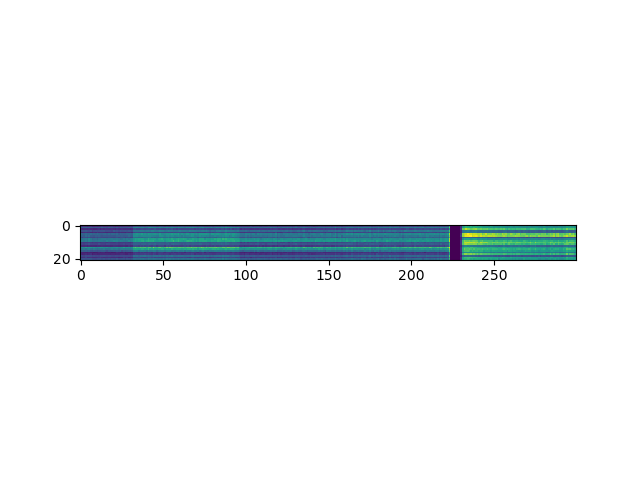

In [6]:
plt.figure()
plt.imshow(RIXS_LA1_Si)
